In [63]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

Importing Data
First we will import the train and test CSV files into a dataframe. We see below all of the features and notice that several have null values. 

In [30]:
df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [32]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Since there are only two missing values in the train data set we will attempt to impute them manually by looking at the names.

In [33]:
print(df.loc[[61,829],:])
df['Embarked'].value_counts()

     PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
61   female  38.0      0      0  113572  80.0   B28      NaN  
829  female  62.0      0      0  113572  80.0   B28      NaN  


S    644
C    168
Q     77
Name: Embarked, dtype: int64

Since the first name appears to be French we will assign C for Cherbourgh. The second name is less obvious so we will assign S since it occurs most frequently.

In [34]:
df.at[61, "Embarked"] = "C" 
df.at[829, "Embarked"] = "S" 

#for test data we will simply assign S
#test_df['Embarked'].fillna('S', inplace=True)

We have only one missing value for Fare so we will just replace with the mean.

In [35]:
df['Fare'].fillna(np.mean(df['Fare']), inplace=True)
test_df['Fare'].fillna(np.mean(df['Fare']), inplace=True)

Since there are many mising values for Cabin we will not attempt to impute missing values. Instead a value of unknown is added if Cabin is null. We also see to extract only the letter of the Cabin and ignore the numbers.

In [36]:
df['Cabin'].fillna(value = 'unknown', inplace=True)
test_df['Cabin'].fillna(value='unknown', inplace=True)

def cabin(cab, letters):
    for letter in letters:
        if letter in cab:
            return letter
    return None

letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

df['Cabin'] = df['Cabin'].map(lambda x: cabin(x, letters))
test_df['Cabin'] = test_df['Cabin'].map(lambda x: cabin(x, letters))

In [37]:
def title(name, titles):
    for title in titles:
        if title in name:
            return title
    return None

title_list = ['Mrs', 'Mr', 'Miss', 'Master']

df['Title'] = df['Name'].map(lambda x: title(x, title_list))
test_df['Title'] = test_df['Name'].map(lambda x: title(x, title_list))

def impute_Nones(x):
    if pd.isnull(x['Title']):
        if x['Sex'] == 'male':
            if x['Age'] <= 12:
                return 'Master'
            else:
                return 'Mr'
        elif x['Sex'] == 'female':
            if x['Age'] >= 23:
                return 'Mrs'
            else:
                return 'Miss'
    else:
        return x['Title']

df['Title'] = df.apply(impute_Nones, axis=1)
test_df['Title'] = df.apply(impute_Nones, axis=1)


df['Title'].value_counts()

Mr        537
Miss      180
Mrs       134
Master     40
Name: Title, dtype: int64

mrs_mean_age: 35.47008547008547
mr_mean_age: 32.98441247002398
miss_mean_age: 21.77777777777778
master_mean_age: 4.574166666666667


<AxesSubplot:>

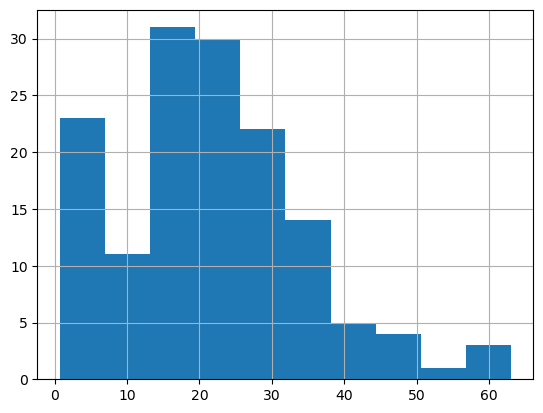

In [38]:
mrs = df.loc[df['Title'] == 'Mrs']
mrs_mean_age = np.mean(mrs['Age'])

mr = df.loc[df['Title'] == 'Mr']
mr_mean_age = np.mean(mr['Age'])

miss = df.loc[df['Title'] == 'Miss']
miss_mean_age = np.mean(miss['Age'])

master = df.loc[df['Title'] == 'Master']
master_mean_age = np.mean(master['Age'])

print('mrs_mean_age:', mrs_mean_age)
print('mr_mean_age:', mr_mean_age)
print('miss_mean_age:', miss_mean_age)
print('master_mean_age:', master_mean_age)
miss['Age'].hist()

In [39]:
def impute_ages(x):
    if pd.isnull(x['Age']):
        if x['Title'] == 'Mrs':
            return 35
        elif x['Title'] == 'Master':
            return 4.5
        elif x['Title'] == 'Miss':
            return 22
        else:
            return 33
    else:
        return x['Age']

df['Age'] = df.apply(impute_ages, axis=1)
test_df['Age'] = df.apply(impute_ages, axis=1)

<AxesSubplot:>

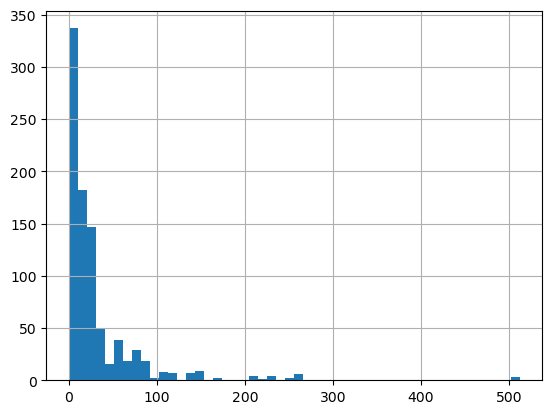

In [40]:
df['Fare'].hist(bins = 50)

<AxesSubplot:>

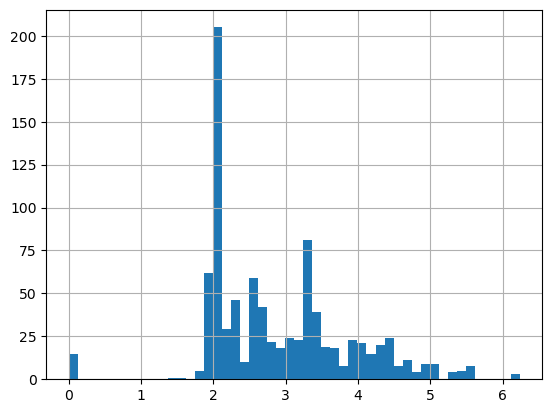

In [41]:
df['Fare'] = df['Fare'].map(lambda x: np.log(x) if x > 0 else 0)
test_df['Fare'] = test_df['Fare'].map(lambda x: np.log(x) if x > 0 else 0)
df['Fare'].hist(bins = 50)

In [46]:
#df = pd.get_dummies(df, columns = ['Title', 'Embarked', 'Cabin'])
#test_df = pd.get_dummies(test_df, columns = ['Title', 'Embarked', 'Cabin'])
df = pd.get_dummies(df, columns = ['Embarked', 'Cabin'])
test_df = pd.get_dummies(test_df, columns = ['Embarked', 'Cabin'])
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,...,0,0,1,0,0,0,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,...,1,0,0,0,0,1,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,...,0,0,1,0,0,0,0,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,...,0,0,1,0,0,1,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,...,0,0,1,0,0,0,0,0,0,0


In [47]:
encoder = preprocessing.LabelEncoder()

features = ['Sex']
for feature in features:
    df[feature] = encoder.fit_transform(df[feature])
    test_df[feature] = encoder.fit_transform(test_df[feature])

test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Title,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G
0,892,3,"Kelly, Mr. James",1,22.0,0,0,330911,2.057860,Mr,0,1,0,0,0,0,0,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,38.0,1,0,363272,1.945910,Mrs,0,0,1,0,0,0,0,0,0,0
2,894,2,"Myles, Mr. Thomas Francis",1,26.0,0,0,240276,2.270836,Miss,0,1,0,0,0,0,0,0,0,0
3,895,3,"Wirz, Mr. Albert",1,35.0,0,0,315154,2.159003,Mrs,0,0,1,0,0,0,0,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,35.0,1,1,3101298,2.508582,Mr,0,0,1,0,0,0,0,0,0,0


In [48]:
#make test and train data
y = df['Survived']
X = df.drop(['Survived', 'PassengerId', 'Ticket', 'Name', 'Title'], axis=1)

X_submission = test_df.drop(['PassengerId', 'Ticket', 'Name', 'Title'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G
0,3,1,22.0,1,0,1.981001,0,0,1,0,0,0,0,0,0,0
1,1,0,38.0,1,0,4.266662,1,0,0,0,0,1,0,0,0,0
2,3,0,26.0,0,0,2.070022,0,0,1,0,0,0,0,0,0,0
3,1,0,35.0,1,0,3.972177,0,0,1,0,0,1,0,0,0,0
4,3,1,35.0,0,0,2.085672,0,0,1,0,0,0,0,0,0,0


### Creating Models
Here I have chose 5 different models to evaluate: 
* Gradient Boost Classifier
* Logistic Regression
* Random Forest
* KNN
* SVM

Below all of the models are fit with the training data and a crossvalidation score is assigned with 10 folds. Several of the models with hyperparameters are tuned using an exhaustive grid search. 

**Gradient Boosting Classifier**

In [145]:
grid_size = 5
n_estimators = (np.linspace(10,200,grid_size,dtype=int))
learning_rates = np.logspace(start=-2, stop=1,num=grid_size)
max_depth = np.arange(1,3)
parameters = {'n_estimators':n_estimators,'max_depth':max_depth, 'learning_rate':learning_rates}

grid = GridSearchCV(GradientBoostingClassifier(random_state=0), parameters, refit=True, cv=5)
clf = grid.fit(x_train,y_train)
grid.best_params_

{'learning_rate': 0.05623413251903491, 'max_depth': 2, 'n_estimators': 200}

In [99]:
gb_clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=2,ccp_alpha=0.0015, random_state=0).fit(X,y)
gb_cv = np.mean(cross_val_score(gb_clf, X, y, cv=10))

**Logstic Regression**

In [50]:
lr_clf = LogisticRegression(max_iter=1000).fit(x_train, y_train)
lr_cv = np.mean(cross_val_score(lr_clf, X, y, cv=10))

**Random Forest**

In [114]:
grid_size = 20
ccp_alpha = np.logspace(start=-3, stop=1,num=grid_size)
max_depth = np.arange(1,4)
parameters = {'ccp_alpha':ccp_alpha, 'max_depth':max_depth}

grid = GridSearchCV(RandomForestClassifier(n_estimators=200,random_state=0), parameters, refit=True, cv=10)
clf = grid.fit(X,y)
grid.best_params_

KeyboardInterrupt: 

In [111]:
rf_clf = RandomForestClassifier(n_estimators = 200, max_depth=4, max_features='sqrt', ccp_alpha=0.0015, random_state=0).fit(X, y)
rf_cv = np.mean(cross_val_score(rf_clf, X, y, cv=10))

**KNN**

In [73]:
knn_clf = KNeighborsClassifier(n_neighbors = 3).fit(X,y)
knn_cv = np.mean(cross_val_score(knn_clf, X, y, cv=10))

**SVM**

In [102]:
grid_size = 20

C = np.logspace(start=-5, stop=5, num=grid_size, base=2)
gamma = np.logspace(start=-5, stop=5, num=grid_size, base=2)
parameters = {'C':C, 'gamma':gamma}

grid = GridSearchCV(SVC(kernel='rbf'), parameters, refit=True,cv=10)
clf = grid.fit(X,y)
grid.best_params_

{'C': 2.489385178928047, 'gamma': 0.06482219027788699}

In [103]:
svm_clf = SVC(kernel='rbf', C=2.5, gamma=0.05).fit(X,y)
svm_cv = np.mean(cross_val_score(svm_clf, X,y,cv=10))

**Cross Validation Scores**

Here we compare the cross validation scores of each classifier after some parameter tuning

In [112]:
models = pd.DataFrame({'Model': ['Gradient Boost', 'Logistic Regression', 'Random Forest', 'KNN', 'SVM'],
                      '10_Fold_CV_Score': [gb_cv, lr_cv, rf_cv, knn_cv, svm_cv]})
models.sort_values(by='10_Fold_CV_Score', ascending=False)

,Model,10_Fold_CV_Score
2,Random Forest,0.835056
4,SVM,0.819313
0,Gradient Boost,0.809276
1,Logistic Regression,0.792409
3,KNN,0.766567


### Model Evaluation

**Metrics** 

We have already used crossvalidation above to compare the models, but below we do a split on the train data to evaluate other parameters. We must split because the test data for submission does not have labels. The below function calculates the following for each classifer:
* Accuracy
* F1 Score
* ROC Curve
* Area under ROC curve
* Confusion Matrix

In [115]:
def evaluate_model(model, x_test, y_test, estimator_name):
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=clf.classes_).plot()
    print('Accuracy Score:', accuracy_score(y_test, y_pred))
    print('F1 Score:', f1_score(y_test, y_pred))
    print('roc_auc_score:', roc_auc_score(y_test, y_pred, average='weighted'))
    ypp = model.predict_proba(x_test)
    fpr, tpr, th = roc_curve(y_test, ypp[:,1], pos_label=clf.classes_[1])
    roc_auc = roc_auc_score(y_test, y_pred, average='weighted')
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name=estimator_name).plot()

**Gradient Boost Metrics**

GradientBoost Metrics
Accuracy Score: 0.8156424581005587
F1 Score: 0.7555555555555555
roc_auc_score: 0.7989697443922795


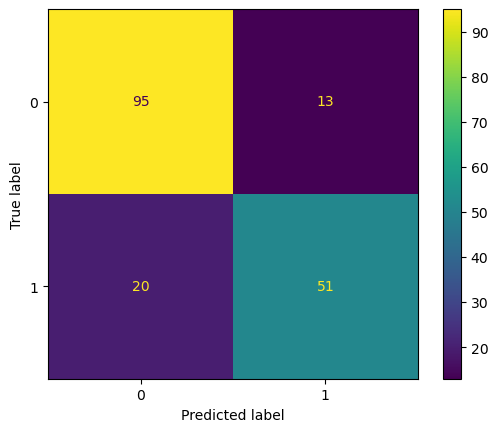

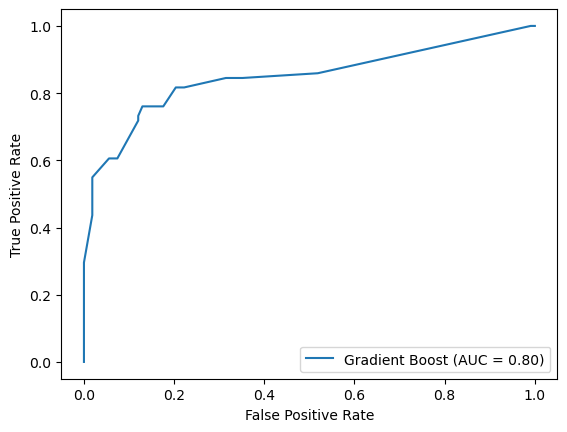

In [116]:
print('GradientBoost Metrics')
estimator_name = 'Gradient Boost'                                 
evaluate_model(gb_clf, x_test, y_test, estimator_name)

Logistic Regression Metrics
Accuracy Score: 0.8100558659217877
F1 Score: 0.7500000000000001
roc_auc_score: 0.7927112949082451


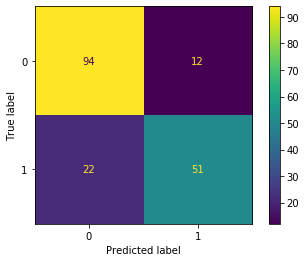

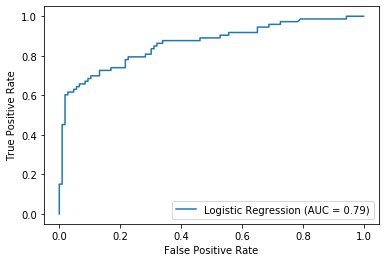

In [60]:
print('Logistic Regression Metrics')
estimator_name = 'Logistic Regression'
evaluate_model(clf1, x_test, y_test, estimator_name)

In [113]:
submission_predictions = rf_clf.predict(X_submission)
submission = pd.DataFrame({'PassengerId':test_df['PassengerId'], 'Survived':submission_predictions})
submission.to_csv('submission.csv', index=False)

In [42]:
submission_test = pd.DataFrame({'PassengerId':test_df['PassengerId'], 'Survived':submission_predictions, 'Name':test_df['Name']})
submission_test.to_csv('sub_test.csv', index=False)